***An experiment to predict the gage height of one of the river with site_id=07377754 of four rivers of comite river. The experiment uses the time-series data of gage height values for these rivers and predict for the downstream river. ***

In [1]:
import os
import time

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

from tqdm import tqdm_notebook
from sklearn.preprocessing import MinMaxScaler

In [ ]:
## Trying out GRU for gage height prediction


In [3]:
df = pd.read_csv("comite_river_dataset_2017_2018.csv", parse_dates=[0])

In [4]:
df.head()

,Date/Time,gage_height_ft_sensor_07377600,gage_height_ft_sensor_07377500,gage_height_ft_sensor_07377754,gage_height_ft_sensor_07377750
0,2017-01-04 13:30:00-06:00,18.58,4.880,6.11,8.29
1,2017-01-04 13:45:00-06:00,18.57,4.855,6.10,8.28
2,2017-01-04 14:00:00-06:00,18.54,4.830,6.11,8.26
3,2017-01-04 14:15:00-06:00,18.52,4.800,6.07,8.25
4,2017-01-04 14:30:00-06:00,18.50,4.770,6.08,8.23


In [10]:
df.shape

(69736, 5)

In [5]:
# split data into train/test
test_portion = int(0.1 * len(df))
train_df = df[:-test_portion]
test_df = df[-test_portion:]

In [6]:
test_df.head()

,Date/Time,gage_height_ft_sensor_07377600,gage_height_ft_sensor_07377500,gage_height_ft_sensor_07377754,gage_height_ft_sensor_07377750
62763,2018-10-20 08:30:00-06:00,13.34,-0.34,1.34,2.9
62764,2018-10-20 08:45:00-06:00,13.34,-0.34,1.34,2.9
62765,2018-10-20 09:00:00-06:00,13.34,-0.34,1.34,2.9
62766,2018-10-20 09:15:00-06:00,13.34,-0.34,1.34,2.9
62767,2018-10-20 09:30:00-06:00,13.34,-0.34,1.34,2.9


In [11]:
sc = MinMaxScaler()
label_sc = MinMaxScaler()

def get_inputs_and_labels(df):
  try:
    df = df.sort_values("Date/Time").drop("Date/Time",axis=1)
  except KeyError:
    df = df.drop("Unnamed: 0", axis=1)

  data = sc.fit_transform(df.values)
  # getting the scale for labels so that the output can be re-scaled to actual value for evaluation
  label_sc.fit(df.iloc[:, 2].values.reshape(-1,1)) # prediction labels for gage_height_ft_sensor_07377754

  # define lookback period and split inputs/labels 
  lookback = 90 #4
  inputs = np.zeros((len(data)-lookback, lookback, data.shape[1]))
  labels = np.zeros(len(data)-lookback)

  # fill the variables with data
  for i in range(lookback, len(df)):
      inputs[i-lookback] = data[i-lookback:i]
      labels[i-lookback] = data[i, 2]
  inputs = inputs.reshape(-1, lookback, df.shape[1])
  labels = labels.reshape(-1,1)
  return inputs, labels

  # # split data into train/test
  # test_portion = int(0.1 * len(inputs))
  # train_x = inputs[:-test_portion]
  # train_y = labels[:-test_portion]

  # test_x = inputs[-test_portion:]
  # test_y = labels[-test_portion:]

In [12]:
train_x, train_y = get_inputs_and_labels(train_df)
test_x, test_y = get_inputs_and_labels(test_df)

In [14]:
# using pytorch for splitting data in batches and shuffling
batch_size = 1024
train_data = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size, drop_last=True)

# torch.cuda.is_available() checks and returns a Boolean True if a GPU is available, else it'll return False
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [15]:
class GRUNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_layers, drop_prob=0.2):
        super(GRUNet, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        
        self.gru = nn.GRU(input_dim, hidden_dim, n_layers, batch_first=True, dropout=drop_prob)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()
        
    def forward(self, x, h):
        out, h = self.gru(x, h)
        out = self.fc(self.relu(out[:, -1]))
        return out, h
    
    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device)
        return hidden
    
class LSTMNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_layers, drop_prob=0.2):
        super(LSTMNet, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, n_layers, batch_first=True, dropout=drop_prob)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()
        
    def forward(self, x, h):
        out, h = self.lstm(x, h)
        out = self.fc(self.relu(out[:, -1]))
        return out, h
    
    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device),
                 weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device))
        return hidden
        

In [16]:
def train(train_loader, learn_rate, hidden_dim=256, EPOCHS= 5, model_type="GRU"):
    # setting hyperparameter
    input_dim = next(iter(train_loader))[0].shape[2]
    output_dim = 1
    n_layers = 2
    
    # instantiate model
    if model_type == "GRU":
        model = GRUNet(input_dim, hidden_dim, output_dim, n_layers)
    else:
        model = LSTMNet(input_dim, hidden_dim, output_dim, n_layers)
        
    model.to(device)
    
    # define loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learn_rate)
    
    model.train()
    print(f"Starting training of {model_type} model.")
    epoch_times = []
    # starting training loop
    for epoch in range(1, EPOCHS+1):
        start_time = time.time()
        h = model.init_hidden(batch_size)
        avg_loss = 0
        counter = 0
        print(f"test {counter}")
        for x, label in train_loader:
            counter += 1
            if model_type == "GRU":
                h = h.data
            else:
                h = tuple([e.data for e in h])
            model.zero_grad()
            
            out, h = model(x.to(device).float(), h)
            loss = criterion(out, label.to(device).float())
            loss.backward()
            optimizer.step()
            avg_loss += loss.item()
            if counter%200 == 0:
                print("Epoch {}......Step: {}/{}....... Average Loss for Epoch: {}".format(epoch, counter, len(train_loader), avg_loss/counter))
        current_time = time.time()
        print("Epoch {}/{} Done, Total Loss: {}".format(epoch, EPOCHS, avg_loss/len(train_loader)))
        print("Total Time Elapsed: {} seconds".format(str(current_time-start_time)))
        epoch_times.append(current_time-start_time)
    print("Total Training Time: {} seconds".format(str(sum(epoch_times))))
    return model
        

In [23]:
lr = 0.001
gru_model = train(train_loader, lr, EPOCHS=20, model_type="GRU")
# lstm_model = train(train_loader, lr, EPOCHS=10, model_type="LSTM")

Starting training of GRU model.
test 0
Epoch 1/20 Done, Total Loss: 0.001086689005429345
Total Time Elapsed: 15.902952194213867 seconds
test 0
Epoch 2/20 Done, Total Loss: 4.857717675670264e-05
Total Time Elapsed: 15.767722368240356 seconds
test 0
Epoch 3/20 Done, Total Loss: 3.394303280029056e-05
Total Time Elapsed: 15.896449565887451 seconds
test 0
Epoch 4/20 Done, Total Loss: 2.7152135965584196e-05
Total Time Elapsed: 15.88573169708252 seconds
test 0
Epoch 5/20 Done, Total Loss: 2.2252964433883774e-05
Total Time Elapsed: 15.897037267684937 seconds
test 0
Epoch 6/20 Done, Total Loss: 1.851791752355372e-05
Total Time Elapsed: 15.855597972869873 seconds
test 0
Epoch 7/20 Done, Total Loss: 2.0264946304778872e-05
Total Time Elapsed: 15.925801992416382 seconds
test 0
Epoch 8/20 Done, Total Loss: 1.5282796546850225e-05
Total Time Elapsed: 15.845597743988037 seconds
test 0
Epoch 9/20 Done, Total Loss: 1.3751491499787051e-05
Total Time Elapsed: 15.851799964904785 seconds
test 0
Epoch 10/20 D

In [24]:
def evaluate(model, test_x, test_y, label_sc):
    model.eval()
    start_time = time.time()
    inp = torch.from_numpy(np.array(test_x))
    labs = torch.from_numpy(np.array(test_y))
    h = model.init_hidden(inp.shape[0])
    print(f"device: {device}")
    out, h = model(inp.to(device).float(), h)
    outputs = label_sc.inverse_transform(out.cpu().detach().numpy()).reshape(-1)
    targets = label_sc.inverse_transform(labs.numpy()).reshape(-1)
    print(f"Evaluation Time: {str(time.time()-start_time)}")
    sMAPE = 0
    sMAPE = np.mean(abs(outputs - targets)/(targets+outputs))
    print(f"sMAPE: {sMAPE * 100}")
    return outputs, targets, sMAPE


In [25]:
gru_outputs, targets, sMAPE = evaluate(gru_model, test_x, test_y, label_sc)


device: cuda
Evaluation Time: 0.48554205894470215
sMAPE: 0.47129655543545573


In [ ]:
# lstm_outputs, targets, lstm_sMAPE = evaluate(lstm_model, test_x, test_y, label_sc)


device: cuda
Evaluation Time: 0.04979276657104492
sMAPE: 1.0565729892987483


In [26]:
lookback = 90 #4
df1 = pd.DataFrame()
df1["Date/Time"] = test_df[lookback:]["Date/Time"]
df1["actual"] = test_df[lookback:]["gage_height_ft_sensor_07377754"]
df1["pred"] = gru_outputs
df1.to_csv("result.csv")

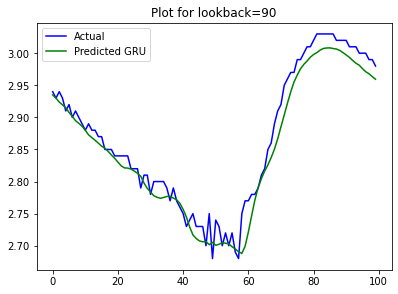

In [27]:
### Ploting the outputs
import matplotlib.pyplot as plt

plt.figure(figsize=(14,10))
plt.subplot(2,2,1)
plt.plot(targets[-100:], color="b", label="Actual")
plt.plot(gru_outputs[-100:], color="g", label="Predicted GRU")
# plt.plot(lstm_outputs[-100:], color="r", label="Predicted LSTM")
plt.title('Plot for lookback=90')
plt.legend()

In [28]:
torch.save(gru_model.state_dict(), "gru_model_lookback90_epoch50") 

In [29]:
torch.save(gru_model, "gru_model_lookback90_full+epoch50")